In [54]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from adaptive import notebook_extension, Runner, Learner2D #https://github.com/python-adaptive/adaptive
notebook_extension()
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "font.family": 'serif'
})
from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression, enet_path, lasso_path
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
ϵ = 1e-8

#### Loading datasets

In [47]:
def load_chignolin_dataset(data_paths, regex_filter = 'ca|cphi|sphi|cpsi|spsi|cchi|schi|o-n', sub_sampling = 1, shuffle = True, scaling=True, with_features = False):
    sub_sampling = 1
    headers = pd.read_csv(data_paths[0][0],sep=' ',skipinitialspace=True, nrows=0).columns[2:]
    raw_inputs = []
    raw_outputs = []
    for data_path in data_paths:
        filename = data_path[0]
        classification_idx = data_path[1] 
        df = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#') 
        #select subset of columns based on names
        filtered_df = df.filter(regex=regex_filter)
        raw_inputs.append(filtered_df.values[::sub_sampling, :])
        raw_outputs.append(classification_idx*np.ones(filtered_df.shape[0])[::sub_sampling])
    features = df.filter(regex=regex_filter).columns
    inputs = np.vstack(raw_inputs)
    outputs = np.hstack(raw_outputs)
    
    if shuffle:
        perm = np.random.permutation(outputs.shape[0])
        inputs = inputs[perm]
        outputs = outputs[perm]
    
    if scaling:
        scaler = StandardScaler(with_mean=True)
        scaler.fit(inputs)
        inputs = (scaler.transform(inputs), scaler.mean_, scaler.var_)
    
    if with_features:
        return inputs, outputs, perm, features
    else:
        return inputs, outputs, perm

In [48]:
train_data_paths = [('../data/chignolin/train-set/folded.dat', 1), ('../data/chignolin/train-set/unfolded.dat', -1)]
test1_data_paths = [('../data/chignolin/test-set-1/folded.dat', 1), ('../data/chignolin/test-set-1/unfolded.dat', -1)]
test2_data_paths = [('../data/chignolin/test-set-2/folded.dat', 1), ('../data/chignolin/test-set-2/unfolded.dat', -1)]

filters = [
            'ca', 
            'ca|cphi|sphi|cpsi|spsi',
            'ca|cchi|schi|o-n',
            'cchi|schi|o-n',
            'o-n',
            'ca|cphi|sphi|cpsi|spsi|cchi|schi|o-n'          
          ]

(train_in, train_means, train_vars), train_out, train_perm, features = load_chignolin_dataset(train_data_paths, shuffle=True, sub_sampling = 2, with_features=True)
(test_in, test_means, test_vars), test_out, test_perm =  load_chignolin_dataset(test1_data_paths, shuffle=True)
(val_in, val_means, val_vars), val_out, val_perm =  load_chignolin_dataset(test2_data_paths, shuffle=True)

### Model

In [4]:
def validation_error(model):
    model.sparse_coef_ = csr_matrix(model.coef_)
    max_features = 10
    score_feat = 1 - np.clip(model.sparse_coef_.count_nonzero(), None, max_features)/max_features
    score_val = np.around(model.score(val_in, val_out), decimals=2)
    α = 0
    score = α*score_feat + (1 - α)*score_val
    return score

def plotter(learner):
    plot = learner.plot(tri_alpha=0.2).opts(xlabel='C', ylabel='ρ')
    return plot

In [7]:
def adaptive_sampling(x):
    C, ρ = x
    model = LogisticRegression(penalty='elasticnet', C=C, solver='saga', l1_ratio=ρ, max_iter=100)
    model.fit(train_in,train_out)
    score = validation_error(model)
    return score

In [103]:

learner = Learner2D(adaptive_sampling, bounds=[(ϵ, 0.5e-3), (ϵ,1 - ϵ)])
runner = Runner(learner, goal=lambda l: l.loss() < 0.005)
runner.live_info()
runner.live_plot(plotter=plotter, update_interval=0.1)

Button(description='cancel live-plot', layout=Layout(width='150px'), style=ButtonStyle())

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (z)
      .EdgePaths.I :EdgePaths   [x,y]

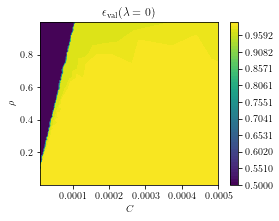

In [116]:
fig, ax = plt.subplots(figsize=(4,3))
data = learner.interpolated_on_grid()
contour = ax.contourf(data[0],data[1],data[2].T, np.linspace(0.5 - ϵ, 1 + ϵ, 50))
ax.set_xlabel(r"$C$")
ax.set_ylabel(r"$\rho$")
ax.set_title(r"$\epsilon_{{\rm val}}(\lambda = 0)$")
#CS = ax.contour(data[0],data[1],data[2].T,5, colors='w')
#ax.clabel(CS, inline=True, fontsize=10, colors='w')
plt.colorbar(contour)
#plt.savefig('chignolin_validation_error.jpeg', dpi=300)

In [117]:
_temp_function = lambda x :-np.float(learner.interpolator()((x[0],x[1])))

In [118]:
optimum = minimize(_temp_function, np.array([0.0003, 0.8]), bounds = [(1e-8, 0.5e-3), (ϵ,1 - ϵ)]).x

In [119]:
optimum

array([3.e-04, 8.e-01])

In [56]:
C_range = np.linspace(ϵ,0.0003,200)
ρ_range = [0.5, 0.8]
data = []
for ρ in ρ_range:
    coeffs = []
    for C in tqdm(C_range, desc=f"ρ = {ρ}"):
        model = LogisticRegression(penalty='elasticnet', C=C, solver='saga', l1_ratio=ρ, max_iter=1000)
        #Model Fit
        model.fit(train_in,train_out)
        coeffs.append(model.coef_)
    coeffs = np.squeeze(np.array(coeffs))
    data.append((coeffs, ρ))

ρ = 0.8: 100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


In [6]:
styles = ['k-', 'b-', 'r-']

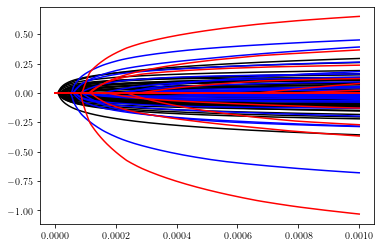

In [7]:
for idx, x in enumerate(data):    
    plt.plot(C_range, x[0], styles[idx],  );

In [51]:
model = LogisticRegression(penalty='elasticnet', C=0.00015, solver='saga', l1_ratio=0.8)
#Model Fit
model.fit(train_in,train_out)
#Model Plot
model.sparse_coef_ = csr_matrix(model.coef_)
model_idxs = model.sparse_coef_.indices
light_data = np.split(train_in[np.argsort(train_perm)][:,model_idxs], 2)

In [52]:
print("The relevant features are:")
w_norm = np.linalg.norm(model.sparse_coef_.data)
weights = []
names = []
for idx in model.sparse_coef_.indices:
    coeff = np.around(model.sparse_coef_[0,idx], decimals = 3)
    weight = np.around(coeff**2/w_norm**2, decimals = 2)
    print(f"{features[idx]} with coefficient {coeff} and relative weight {weight}")
    weights.append(weight)
    names.append(features[idx])
weights = np.array(weights)
perm_sort = np.argsort(weights)[::-1]
weights = weights[perm_sort]
model_idxs = model.sparse_coef_.indices[perm_sort]
names = np.array(names)[perm_sort]

The relevant features are:
o-n1 with coefficient 0.065 and relative weight 0.02
o-n3 with coefficient 0.067 and relative weight 0.02
o-n8 with coefficient 0.26 and relative weight 0.31
cchi1-3 with coefficient -0.376 and relative weight 0.64
ca-5_147 with coefficient -0.06 and relative weight 0.02


### Model plotting

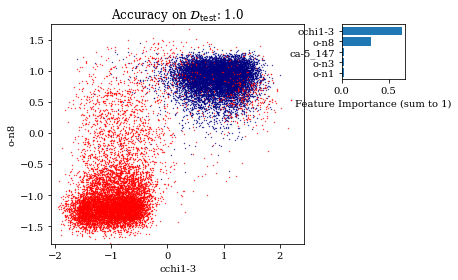

In [55]:
accuracy = np.around(model.score(test_in, test_out), decimals=2)
if len(model_idxs) == 2:

    bdry_sup = np.maximum(np.max(light_data[0][:,0]), np.max(light_data[1][:,0]))
    bdry_inf = np.minimum(np.min(light_data[0][:,0]), np.min(light_data[1][:,0]))
    y_sup = np.maximum(np.max(light_data[0][:,1]), np.max(light_data[1][:,1]))
    y_inf = np.minimum(np.min(light_data[0][:,1]), np.min(light_data[1][:,1]))

    boundary_x = np.linspace(bdry_inf,bdry_sup,2)
    boundary_y = -(boundary_x* model.sparse_coef_[0,model_idxs[0]] + model.intercept_)/model.sparse_coef_[0,model_idxs[1]]
    #Plotting
    fig, ax = plt.subplots()
    ax.set_xlabel(features[model_idxs[0]])
    ax.set_ylabel(features[model_idxs[1]])
    ax.set_xlim(bdry_inf,bdry_sup)
    ax.set_ylim(y_inf,y_sup)
    ax.scatter(light_data[0][:,0], light_data[0][:,1], marker='.', s=0.5, c='navy', alpha=0.5)
    ax.scatter(light_data[1][:,0], light_data[1][:,1], marker='.', s= 0.5, c='r', alpha=0.5)
    ax.plot(boundary_x, boundary_y, 'k--')

elif len(model_idxs) ==1:
    fig, ax = plt.subplots()
    ax.hist(light_data[0], bins=200, color='navy', alpha=0.5, density=True);
    ax.hist(light_data[1], bins= 200, color='r', alpha=0.5, density=True);
    val = -model.intercept_/model.sparse_coef_.data[0]
    ax.plot([val,val] ,[0,1], 'k-', lw=0.5)
    ax.text(val, 1.1, 'Decision bound', ha='center')
    print(f'Decision bound at {val}')
if len(model_idxs) > 2:
    bdry_sup = np.maximum(np.max(light_data[0][:,0]), np.max(light_data[1][:,0]))
    bdry_inf = np.minimum(np.min(light_data[0][:,0]), np.min(light_data[1][:,0]))
    y_sup = np.maximum(np.max(light_data[0][:,1]), np.max(light_data[1][:,1]))
    y_inf = np.minimum(np.min(light_data[0][:,1]), np.min(light_data[1][:,1]))
    
    #Plotting
    fig, ax = plt.subplots(figsize=(7,4))
    ax.set_xlabel(features[model_idxs[0]])
    ax.set_ylabel(features[model_idxs[1]])
    ax.set_xlim(bdry_inf,bdry_sup)
    ax.set_ylim(y_inf,y_sup)
    ax.scatter(light_data[0][:,0], light_data[0][:,1], marker='.', s=0.5, c='navy')
    ax.scatter(light_data[1][:,0], light_data[1][:,1], marker='.', s= 0.5, c='r')
    ax.set_title(r'Accuracy on $\mathcal{D}_{{\rm test}}$: ' +f'{accuracy}')
    ax_feat = ax.inset_axes([1.15, 0.75, 0.25, 0.25])
    
    y_pos = np.arange(len(names))
    
    ax_feat.barh(y_pos, weights, align='center')
    ax_feat.set_yticks(y_pos)
    ax_feat.set_yticklabels(names)
    ax_feat.invert_yaxis()  # labels read top-to-bottom
    ax_feat.set_xlabel('Feature Importance (sum to 1)')

    plt.tight_layout()
plt.savefig('chignolin_elasticnet_classification.jpeg', dpi=300)

### End-to-end results

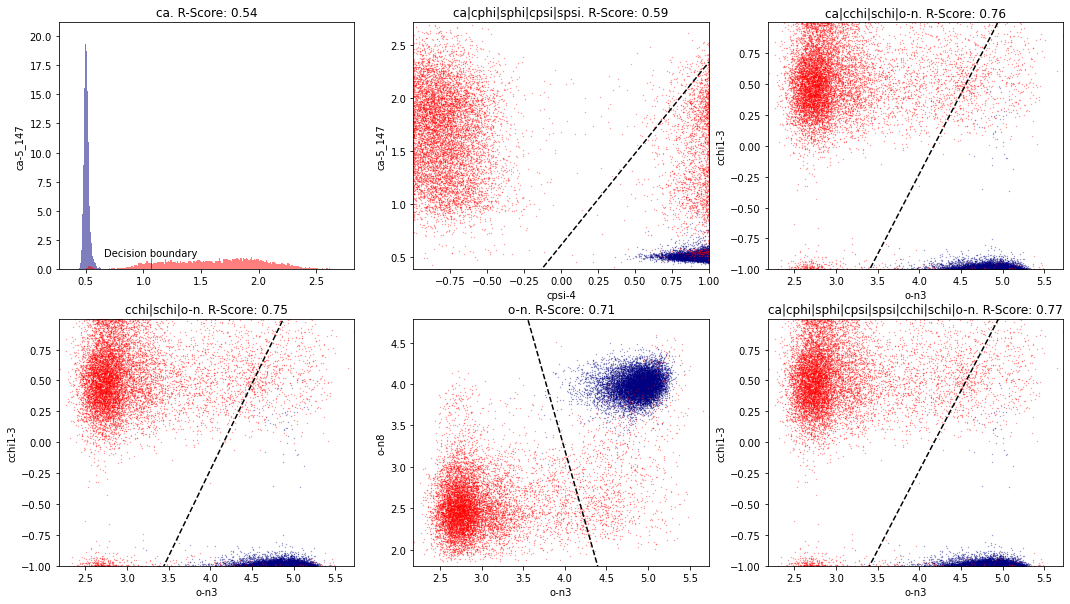

In [338]:
data_paths = [('../data/chignolin/train-set/folded.dat', 1), ('../data/chignolin/train-set/unfolded.dat', -1)]
headers = pd.read_csv(data_paths[0][0],sep=' ',skipinitialspace=True, nrows=0).columns[2:]

filters = [
            ('ca', 0.3), 
            ('ca|cphi|sphi|cpsi|spsi', 0.3),
            ('ca|cchi|schi|o-n', 0.3),
            ('cchi|schi|o-n', 0.3),
            ('o-n', 0.3),
            ('ca|cphi|sphi|cpsi|spsi|cchi|schi|o-n', 0.3),          
          ]
fig, axes = plt.subplots(nrows=2, ncols=3, squeeze=False, figsize=(18,10))


for idx, val in enumerate(filters):
    regex_filter, alpha = val
    ax = axes[np.unravel_index(idx, axes.shape)]

    raw_inputs = []
    raw_outputs = []
    for data_path in data_paths:
        filename = data_path[0]
        classification_idx = data_path[1] 
        df = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#') 
        #select subset of columns based on names
        filtered_df = df.filter(regex=regex_filter)
        raw_inputs.append(filtered_df.values)
        raw_outputs.append(classification_idx*np.ones(filtered_df.shape[0]))
    features = df.filter(regex=regex_filter).columns
    inputs = np.vstack(raw_inputs)
    outputs = np.hstack(raw_outputs)
    
    #Shuffling
    perm = np.random.permutation(outputs.shape[0])
    inputs = inputs[perm]
    outputs = outputs[perm]
    #Test-Train split
    train_frac = 0.8
    len_train = np.int(outputs.shape[0]*train_frac)

    train_in, train_out = inputs[0:len_train], outputs[0:len_train]
    test_in, test_out =  inputs[len_train:], outputs[len_train:]
    
    #Model initialization
    model = Lasso(alpha=alpha, tol= 1e-15, max_iter=100000)
    #Model Fit
    model.fit(train_in,train_out)
    #Model Plot
    model_idxs = model.sparse_coef_.indices
    light_data = [x[:,model_idxs] for x in raw_inputs]
    
    score = np.around(model.score(test_in, test_out), decimals=2)

    if len(model_idxs) == 2:

        bdry_sup = np.maximum(np.max(light_data[0][:,0]), np.max(light_data[1][:,0]))
        bdry_inf = np.minimum(np.min(light_data[0][:,0]), np.min(light_data[1][:,0]))
        y_sup = np.maximum(np.max(light_data[0][:,1]), np.max(light_data[1][:,1]))
        y_inf = np.minimum(np.min(light_data[0][:,1]), np.min(light_data[1][:,1]))

        boundary_x = np.linspace(bdry_inf,bdry_sup,2)
        boundary_y = -(boundary_x* model.sparse_coef_[0,model_idxs[0]] + model.intercept_)/model.sparse_coef_[0,model_idxs[1]]
        #Plotting
        
        ax.set_xlabel(features[model_idxs[0]])
        ax.set_ylabel(features[model_idxs[1]])
        ax.set_title(f"{regex_filter}. R-Score: {score}")
        ax.set_xlim(bdry_inf,bdry_sup)
        ax.set_ylim(y_inf,y_sup)
        ax.scatter(light_data[0][:,0], light_data[0][:,1], marker='.', s=0.5, c='navy', alpha=0.5)
        ax.scatter(light_data[1][:,0], light_data[1][:,1], marker='.', s= 0.5, c='r', alpha=0.5)
        ax.plot(boundary_x, boundary_y, 'k--')


    elif len(model_idxs) ==1:
        ax.set_title(f"{regex_filter}. R-Score: {score}")
        ax.hist(light_data[0], bins=200, color='navy', alpha=0.5, density=True);
        ax.hist(light_data[1], bins= 200, color='r', alpha=0.5, density=True);
        ax.set_ylabel(features[model_idxs[0]])
        val = -model.intercept_/model.sparse_coef_.data[0]
        ax.plot([val,val] ,[0,1], 'k-', lw=0.5)
        ax.text(val, 1.1, 'Decision boundary', ha='center')
    else:
        print(f'Too many coefficients to plot for {regex_filter}')
    plt.savefig('chignolin_classification_alpha03.jpeg')

### Switching to proper classification losses

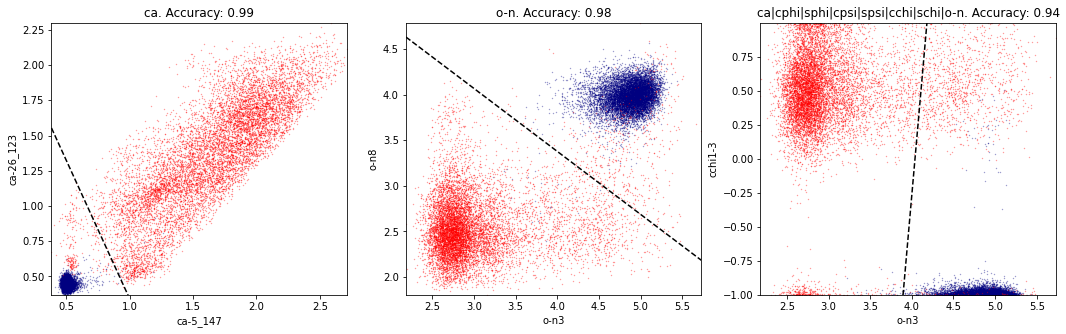

In [423]:
data_paths = [('../data/chignolin/train-set/folded.dat', 1), ('../data/chignolin/train-set/unfolded.dat', -1)]
headers = pd.read_csv(data_paths[0][0],sep=' ',skipinitialspace=True, nrows=0).columns[2:]

filters = [
            ('ca', 0.01), 
            ('o-n', 0.001),
            #('ca|cphi|sphi|cpsi|spsi', 0.0005),
            #('ca|cchi|schi|o-n', 0.0003),
            #('cchi|schi|o-n', 0.0003),
            ('ca|cphi|sphi|cpsi|spsi|cchi|schi|o-n', 0.0003)         
          ]
fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(18,5))


for idx, val in enumerate(filters):
    regex_filter, alpha = val
    ax = axes[np.unravel_index(idx, axes.shape)]

    raw_inputs = []
    raw_outputs = []
    for data_path in data_paths:
        filename = data_path[0]
        classification_idx = data_path[1] 
        df = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#') 
        #select subset of columns based on names
        filtered_df = df.filter(regex=regex_filter)
        raw_inputs.append(filtered_df.values)
        raw_outputs.append(classification_idx*np.ones(filtered_df.shape[0]))
    features = df.filter(regex=regex_filter).columns
    inputs = np.vstack(raw_inputs)
    outputs = np.hstack(raw_outputs)
    
    #Shuffling
    perm = np.random.permutation(outputs.shape[0])
    inputs = inputs[perm]
    outputs = outputs[perm]
    #Test-Train split
    train_frac = 0.8
    len_train = np.int(outputs.shape[0]*train_frac)

    train_in, train_out = inputs[0:len_train], outputs[0:len_train]
    test_in, test_out =  inputs[len_train:], outputs[len_train:]
    
    #Model initialization
    model = LogisticRegression(penalty='l1', C=alpha, solver='saga')
    #Model Fit
    model.fit(train_in,train_out)
    #Model Plot
    model.sparse_coef_ = csr_matrix(model.coef_)
    model_idxs = model.sparse_coef_.indices
    light_data = [x[:,model_idxs] for x in raw_inputs]
    
    score = np.around(model.score(test_in, test_out), decimals=2)

    if len(model_idxs) == 2:

        bdry_sup = np.maximum(np.max(light_data[0][:,0]), np.max(light_data[1][:,0]))
        bdry_inf = np.minimum(np.min(light_data[0][:,0]), np.min(light_data[1][:,0]))
        y_sup = np.maximum(np.max(light_data[0][:,1]), np.max(light_data[1][:,1]))
        y_inf = np.minimum(np.min(light_data[0][:,1]), np.min(light_data[1][:,1]))

        boundary_x = np.linspace(bdry_inf,bdry_sup,2)
        boundary_y = -(boundary_x* model.sparse_coef_[0,model_idxs[0]] + model.intercept_)/model.sparse_coef_[0,model_idxs[1]]
        #Plotting
        
        ax.set_xlabel(features[model_idxs[0]])
        ax.set_ylabel(features[model_idxs[1]])
        ax.set_title(f"{regex_filter}. Accuracy: {score}")
        ax.set_xlim(bdry_inf,bdry_sup)
        ax.set_ylim(y_inf,y_sup)
        ax.scatter(light_data[0][:,0], light_data[0][:,1], marker='.', s=0.5, c='navy', alpha=0.5)
        ax.scatter(light_data[1][:,0], light_data[1][:,1], marker='.', s= 0.5, c='r', alpha=0.5)
        ax.plot(boundary_x, boundary_y, 'k--')


    elif len(model_idxs) ==1:
        ax.set_title(f"{regex_filter}. Accuracy: {score}")
        ax.hist(light_data[0], bins=200, color='navy', alpha=0.5, density=True);
        ax.hist(light_data[1], bins= 200, color='r', alpha=0.5, density=True);
        ax.set_ylabel(features[model_idxs[0]])
        val = -model.intercept_/model.sparse_coef_.data[0]
        ax.plot([val,val] ,[0,1], 'k-', lw=0.5)
        ax.text(val, 1.1, 'Decision boundary', ha='center')
    elif len(model_idxs) == 0:
        print(f'Zero coefficients to plot for {regex_filter}')
    else:
        print(f'Too many coefficients to plot for {regex_filter}')
    #plt.savefig('chignolin_classification_alpha03.jpeg')